# Decision trees and ensemble models

In this notebook, we will look at Decision trees for classification as well as various ensemble models based on decision trees, such as Random Forest and AdaBoost.

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score

We will again use the diabetes dataset as example:

In [24]:
diab_data = pd.read_csv('diabetes.csv')

In [25]:
diab_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [26]:
diab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


For simplicity, we will select only the "Glucose", "BloodPressure", "Insulin", and "BMI" as feature variables, and Outcome as response variable.

In [27]:
X = diab_data[["Glucose", "BloodPressure", "Insulin", "BMI"]]
y = diab_data["Outcome"]

We will also do a train-test split:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8532)

## Decision trees

We need to load the decision tree classifier from Scikit-learn:

In [29]:
from sklearn.tree import DecisionTreeClassifier

The procedure of training a Decision in Scikit-learn is similar to the procedures for training other models:

In [30]:
dtree = DecisionTreeClassifier()

In [31]:
dtree = dtree.fit(X_train, y_train)

In [32]:
y_pred_train = dtree.predict(X_train)
y_pred_test = dtree.predict(X_test)

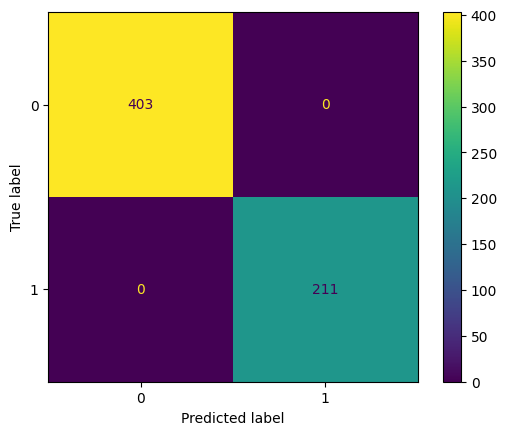

In [33]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot()
plt.show()

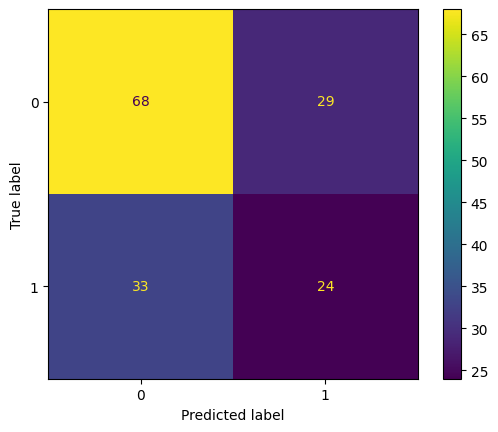

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

In [35]:
accuracy_score(y_train, y_pred_train)

1.0

In [36]:
accuracy_score(y_test, y_pred_test)

0.5974025974025974

There is no doubt that the decision tree clearly overfitted!!!

In [37]:
precision_score(y_train, y_pred_train)

np.float64(1.0)

In [38]:
precision_score(y_test, y_pred_test)

np.float64(0.4528301886792453)

In [39]:
recall_score(y_train, y_pred_train)

np.float64(1.0)

In [40]:
recall_score(y_test, y_pred_test)

np.float64(0.42105263157894735)

In [41]:
f1_score(y_train, y_pred_train)

np.float64(1.0)

In [42]:
f1_score(y_test, y_pred_test)

np.float64(0.43636363636363634)

### Visualizing a decision tree

We can also visualize our decision tree here in the jupyter notebook. Note that decisions trees can become quite big and complex, but it can still be valuable to try to visualize them. To do this, the modules `graphviz` and `pydotplus` needs to be installed into your environment.

In [43]:
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [44]:
feature_cols = ["Glucose", "BloodPressure", "Insulin", "BMI"]

export_graphviz(dtree,
                out_file='DT_diabetes.dot',  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names = feature_cols,
                class_names=['0','1'])

In [45]:
! dot -Tpng DT_diabetes.dot -o DT_diabetes.png

from IPython import display
display.Image("DT_diabetes.png")

'dot' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: No such file or directory: 'DT_diabetes.png'

FileNotFoundError: No such file or directory: 'DT_diabetes.png'

<IPython.core.display.Image object>

### Hyper-parameter tuning

As we saw the decision tree completely overfitted to the training data! Luckily, there are several hyper-parameters we can tune to make it overfit less. Two of them are:

* **criterion**: Measure of the quality of a split of a column. Mainly *gini* and *entropy*
* **max_depth**: The maximum depth of the tree

We can use cross-validation with different values for `criterion` and `max_depth` to determine the potential optimal tune.

In [46]:
criterions = ["gini", "entropy"]
maxDepth = range(1, 30)

In [47]:
CVlist = []
for c in criterions:
    for md in maxDepth:
        # Model intializing
        dtree = DecisionTreeClassifier(criterion=c, max_depth=md)
        # Cross-validation
        scores = cross_val_score(dtree, X_train, y_train, cv = 10)
        CVlist.append({"Criteria": c, "Max depth": md, "CV accuracy": scores.mean()})   
CV_df = pd.DataFrame(CVlist)

In [48]:
CV_df.head()

,Criteria,Max depth,CV accuracy
0,gini,1,0.734585
1,gini,2,0.744342
2,gini,3,0.739529
3,gini,4,0.736304
4,gini,5,0.742834


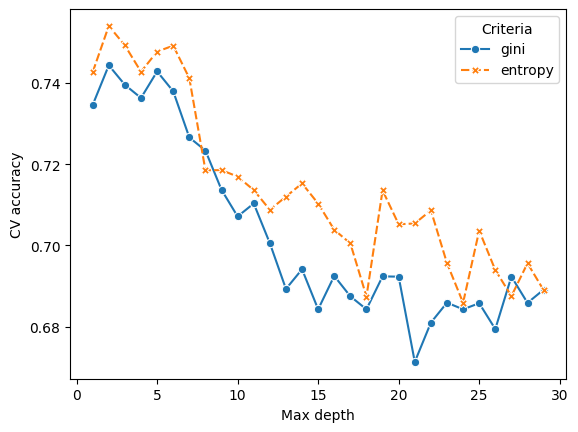

In [49]:
sns.lineplot(data=CV_df, x="Max depth", y="CV accuracy", hue="Criteria", style="Criteria", markers=True)
plt.show()

It looks like the best decision tree is obtained by setting max depth to 2 and the spliting criteria to "entropy", so let us try to do that and evaluate the model on the test dataset:

In [50]:
dtree = DecisionTreeClassifier(criterion="entropy", max_depth=2)
dtree = dtree.fit(X_train, y_train)
y_pred_train = dtree.predict(X_train)
y_pred_test = dtree.predict(X_test)

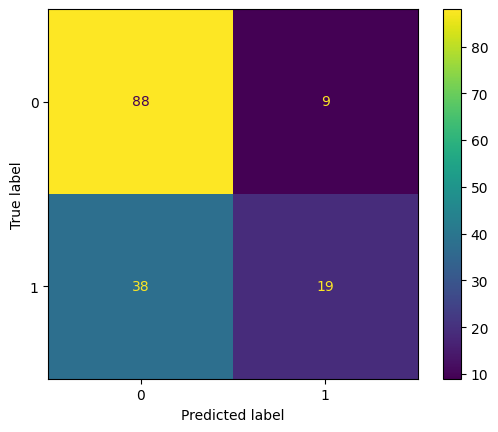

In [51]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

In [52]:
accuracy_score(y_train, y_pred_train)

0.7719869706840391

In [53]:
accuracy_score(y_test, y_pred_test)

0.6948051948051948

There is clearly less overfitting! However, there might be some issue with class balance as only 28 are predicted to have diabetes, while 126 are predicted to not having diabetes. This also indicated by the decent precision, but low recall:

In [54]:
precision_score(y_test, y_pred_test)

np.float64(0.6785714285714286)

In [55]:
recall_score(y_test, y_pred_test)

np.float64(0.3333333333333333)

In [56]:
f1_score(y_test, y_pred_test)

np.float64(0.4470588235294118)

Let us visualize this tree as well:

In [57]:
feature_cols = ["Glucose", "BloodPressure", "Insulin", "BMI"]

export_graphviz(dtree,
                out_file='DT_diabetes_tuned.dot',  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names = feature_cols,
                class_names=['0','1'])

In [58]:
! dot -Tpng DT_diabetes_tuned.dot -o DT_diabetes_tuned.png

from IPython import display
display.Image("DT_diabetes_tuned.png")

'dot' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: No such file or directory: 'DT_diabetes_tuned.png'

FileNotFoundError: No such file or directory: 'DT_diabetes_tuned.png'

<IPython.core.display.Image object>

Now, it is not a perfect tree, but certainly easier to grasp, due to its smaller size.

## Random Forest

We will now try a Random Forest model. to do this we first have to import the right class from Scikit-learn:

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rf_model = RandomForestClassifier() 
rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

In [61]:
accuracy_score(y_train, y_pred_train)

1.0

In [62]:
accuracy_score(y_test, y_pred_test)

0.7012987012987013

It looks like we clearly overfitted again. However, usually Random Forest models are not that prone to overfitting.

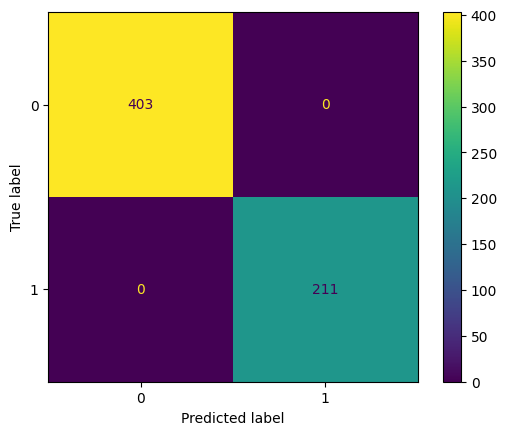

In [63]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot()
plt.show()

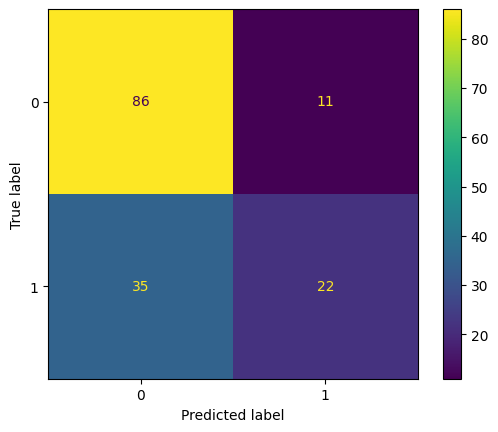

In [64]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

It looks like we have to do some hyper-parameter tuning again. For Random forest there are many hyper-parameters we can tune, but we will only look at two, the number of trees (called `n_estimators` in `RandomForestClassifier`) and the max depth (called `max_depth` in `RandomForestClassifier`). (Other important hyper-parameters one could tune is the minimum number of samples required to split a note and the number of features considered at each split.) We will do this using cross-validation:

In [ ]:
nTrees = [200, 300, 400, 600, 800]
maxDepth = [1, 2, 3, 4, 6, 8, 10, 12]

CVlist = []
for nt in nTrees:
    print("Trying ", nt, " number of trees")
    for md in maxDepth:
        print("Trying a max depth of ", md)
        # Model intializing
        rf_model = RandomForestClassifier(n_estimators=nt, max_depth=md)
        # Cross-validation
        scores = cross_val_score(rf_model, X_train, y_train, cv = 10)
        CVlist.append({"Number of trees": nt, "Max depth": md, "CV accuracy": scores.mean()})   
CV_df = pd.DataFrame(CVlist)

Trying  200  number of trees
Trying a max depth of  1
Trying a max depth of  2
Trying a max depth of  3
Trying a max depth of  4
Trying a max depth of  6
Trying a max depth of  8
Trying a max depth of  10
Trying a max depth of  12
Trying  300  number of trees
Trying a max depth of  1
Trying a max depth of  2
Trying a max depth of  3


Note that this took a long time! We had 5 different number of trees and 8 different number of depth, which means we have to search through 40 combinations of these two hyper-parameters, and for each of these combinations, we trained 10 models (due to 10-fold cross-validation). Thus, in total we just trained 400 models!!! In the class on "Improving and selecting machine learning models", we will talk more about alternatives to this.

In [ ]:
sns.lineplot(data=CV_df, x="Max depth", y="CV accuracy", hue="Number of trees", style="Number of trees", markers=True)
plt.show()

It looks like good option for `n_estimators` and `max_depth` is 800 and 4. Thus, we train a new model on all the training data with these hyper-parameter values:

In [ ]:
rf_model_final = RandomForestClassifier(n_estimators = 800, max_depth = 4) 
rf_model_final.fit(X_train, y_train)
y_pred_train = rf_model_final.predict(X_train)
y_pred_test = rf_model_final.predict(X_test)

In [ ]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Train accuracy:", accuracy_train)
print("Test accuracy:", accuracy_test)

We see that the model no longer overfit as much, but it has not improved the test accuracy that much. Let us look at the confusion matrix on the test dataset:

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

Here we see that we manage to move two false positives into true negatives, but that is all that has changed. Let us also calculate the other evaluation metrics:

In [ ]:
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

Let us finally look at the variable importance to tell us which feature variables are most important in the model's predictions:

In [ ]:
# Collecting the feature importances
feature_importances = pd.Series(rf_model_final.feature_importances_, index=X_train.columns).sort_values(ascending=True)

# Plotting the feature impartances
feature_importances.plot.barh()
plt.title("Variable importance for the final Random Forest classifier")
plt.show()

We see that the Glucose level is clearly the most important feature followed by BMI.

### AdaBoost 

AdaBoost is an example of a powerful boosting algorithm. To use it we need to import the `AdaBoostClassifier` from `sklearn.ensemble`:

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

We can now train an AdaBoost model the way we trained the random forest model:

In [ ]:
ab_model = AdaBoostClassifier() 
ab_model.fit(X_train, y_train)
y_pred_train = ab_model.predict(X_train)
y_pred_test = ab_model.predict(X_test)

In [ ]:
accuracy_score(y_train, y_pred_train)

In [ ]:
accuracy_score(y_test, y_pred_test)

The AdaBoost model does not overfit that much out of the box! Let us look at the Confusion matrix for the test dataset:

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

It makes 3 more false positive than our final Random Forest model, but also 4 less false negatives. Let us also calculate the other evaluation metrics:

In [ ]:
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

It achieved sligtly lower precision, but substainlly higher recall and thereby also a higher f1-score.

Let us look at the variable importance also:

In [ ]:
# Collecting the feature importances
feature_importances = pd.Series(ab_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)

# Plotting the feature impartances
feature_importances.plot.barh()
plt.title("Variable importance for the AdaBoost classifier")
plt.show()

Here we get almost the same as for the Random Forest except that the Insulin feature seems not to be used at all.

If you want, you can try to tune some of AdaBoostøs hyper-parameters on your own. Some important hyper-parameters are:
* **n_estimators**: Number of trees that are trained iteratively.
* **learning_rate**: It contributes to the weights of the trees. It uses 1 as a default value.

### XGBoost

XGBoost is another powerful and very popular variant of a boosting model based on decision trees. There seems to be no implementation of it in Scikit-learn, so we will use a separate module (also used by Shabab in the class on Time Series Analysis).

In [ ]:
import xgboost as xgb

Even though it is not standard Scikit-learn, we can set-up it up the usual way:

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

In [ ]:
accuracy_score(y_train, y_pred_train)

In [ ]:
accuracy_score(y_test, y_pred_test)

It clearly overfitted quite a lot, but that is one of the challenges of XGBoost. We will not do hyper-parameter tuning here, but it would be required to get a good model!

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train)).plot()
plt.show()

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

In [ ]:
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

Clearly here we got a lower precision on our test data. Let us see the variable importance as well:

In [ ]:
# Collecting the feature importances
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)

# Plotting the feature impartances
feature_importances.plot.barh()
plt.title("Variable importance for the AdaBoost classifier")
plt.show()

It still put Glucose on top, but it has rearanged to features in the bottom.

### Decision trees and ensemble methods for regression

As mentioned several times, Decision trees and ensemble methods can also be used for regression. For instance, the Scikit-learn submodule `sklearn.tree` has a class [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). There is also a Random Forest class for regression [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), and an AdaBoost for regression [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html).